<a href="https://colab.research.google.com/github/AsmaMora/Customer_Analytics/blob/main/MADT8101_Customer_single_view.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
%pip install pycaret

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import raw data

In [145]:
path = '/content/drive/MyDrive/Project MADT8101/supermarket.csv'

In [146]:
df_ = pd.read_csv(path)

In [147]:
raw = df_

###Sanity check and clean raw data

In [90]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

Check missing value

In [91]:
#check missing value
raw.isnull().sum()

SHOP_WEEK                        0
SHOP_DATE                        0
SHOP_WEEKDAY                     0
SHOP_HOUR                        0
QUANTITY                         0
SPEND                            0
PROD_CODE                        0
PROD_CODE_10                     0
PROD_CODE_20                     0
PROD_CODE_30                     0
PROD_CODE_40                     0
CUST_CODE                    85588
CUST_PRICE_SENSITIVITY       85588
CUST_LIFESTAGE              144940
BASKET_ID                        0
BASKET_SIZE                      0
BASKET_PRICE_SENSITIVITY         0
BASKET_TYPE                      0
BASKET_DOMINANT_MISSION          0
STORE_CODE                       0
STORE_FORMAT                     0
STORE_REGION                     0
dtype: int64

Remove missing value

In [148]:
# remove rows where CUST_ID is 0
raw = raw.dropna(subset=['CUST_CODE'], how='any', axis=0)

In [93]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492494 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 492494 non-null  int64  
 1   SHOP_DATE                 492494 non-null  int64  
 2   SHOP_WEEKDAY              492494 non-null  int64  
 3   SHOP_HOUR                 492494 non-null  int64  
 4   QUANTITY                  492494 non-null  int64  
 5   SPEND                     492494 non-null  float64
 6   PROD_CODE                 492494 non-null  object 
 7   PROD_CODE_10              492494 non-null  object 
 8   PROD_CODE_20              492494 non-null  object 
 9   PROD_CODE_30              492494 non-null  object 
 10  PROD_CODE_40              492494 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [94]:
#check missing value
raw.isnull().sum()

SHOP_WEEK                       0
SHOP_DATE                       0
SHOP_WEEKDAY                    0
SHOP_HOUR                       0
QUANTITY                        0
SPEND                           0
PROD_CODE                       0
PROD_CODE_10                    0
PROD_CODE_20                    0
PROD_CODE_30                    0
PROD_CODE_40                    0
CUST_CODE                       0
CUST_PRICE_SENSITIVITY          0
CUST_LIFESTAGE              59352
BASKET_ID                       0
BASKET_SIZE                     0
BASKET_PRICE_SENSITIVITY        0
BASKET_TYPE                     0
BASKET_DOMINANT_MISSION         0
STORE_CODE                      0
STORE_FORMAT                    0
STORE_REGION                    0
dtype: int64

Change data type

In [149]:
#change data type
raw['SHOP_DATE'] = pd.to_datetime(raw['SHOP_DATE'], format='%Y%m%d')

<ipython-input-149-adc823cb9329>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['SHOP_DATE'] = pd.to_datetime(raw['SHOP_DATE'], format='%Y%m%d')


###Prepare label column

In [150]:
#create label columns
def map_price_sensitivity(sensitivity):
    if sensitivity == "LA": return "Less Affluent"
    elif sensitivity == "MM": return "Mid Market"
    elif sensitivity == "UM": return "UP Market"
    else: return "Unclas"


raw['CUST_PRICE_SENSITIVITY_LABEL'] = raw['CUST_PRICE_SENSITIVITY'].apply(map_price_sensitivity)


def map_cust_lifestage(lifestage):
    if lifestage == "YA": return "Young Adults"
    elif lifestage == "OA": return "OA"
    elif lifestage == "YF": return "Young Families"
    elif lifestage == "OF": return "Older Adults"
    elif lifestage == "PE": return "Pensioners"
    else: return "Other"


raw['CUST_LIFESTAGE_LABEL'] = raw['CUST_LIFESTAGE'].apply(map_cust_lifestage)


def map_basket_size(size):
    if size == "L": return "Large"
    elif size == "M": return "Medium"
    else: return "Small"


raw['BASKET_SIZE_LABEL'] = raw['BASKET_SIZE'].apply(map_basket_size)


#create code columns
def map_price_sensitivity_cd(sensitivity_cd):
    if sensitivity_cd == "LA": return 0
    elif sensitivity_cd == "MM": return 1
    elif sensitivity_cd == "UM": return 2
    else: return 3


raw['CUST_PRICE_SENSITIVITY_CD'] = raw['CUST_PRICE_SENSITIVITY'].apply(map_price_sensitivity_cd)


def map_cust_lifestage_cd(lifestage_cd):
    if lifestage_cd == "YA": return 0
    elif lifestage_cd == "OA": return 1
    elif lifestage_cd == "YF": return 2
    elif lifestage_cd == "OF": return 3
    elif lifestage_cd == "PE": return 4
    else: return 5


raw['CUST_LIFESTAGE_CD'] = raw['CUST_LIFESTAGE'].apply(map_cust_lifestage_cd)


def map_basket_size_cd(size_cd):
    if size_cd == "L": return 0
    elif size_cd == "M": return 1
    else: return 2


raw['BASKET_SIZE_CD'] = raw['BASKET_SIZE'].apply(map_basket_size_cd)

<ipython-input-150-ecc0747d0245>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['CUST_PRICE_SENSITIVITY_LABEL'] = raw['CUST_PRICE_SENSITIVITY'].apply(map_price_sensitivity)
<ipython-input-150-ecc0747d0245>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['CUST_LIFESTAGE_LABEL'] = raw['CUST_LIFESTAGE'].apply(map_cust_lifestage)
<ipython-input-150-ecc0747d0245>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [151]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492494 entries, 0 to 578081
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   SHOP_WEEK                     492494 non-null  int64         
 1   SHOP_DATE                     492494 non-null  datetime64[ns]
 2   SHOP_WEEKDAY                  492494 non-null  int64         
 3   SHOP_HOUR                     492494 non-null  int64         
 4   QUANTITY                      492494 non-null  int64         
 5   SPEND                         492494 non-null  float64       
 6   PROD_CODE                     492494 non-null  object        
 7   PROD_CODE_10                  492494 non-null  object        
 8   PROD_CODE_20                  492494 non-null  object        
 9   PROD_CODE_30                  492494 non-null  object        
 10  PROD_CODE_40                  492494 non-null  object        
 11  CUST_CODE    

###Create customer sigle view

In [306]:
# Define aggregation functions
aggregations = {
    'SHOP_DATE': ['min', 'max'],
    'BASKET_ID': 'nunique',
    'SPEND': 'sum'
}

# Group by specified columns and apply aggregations
summary = raw.groupby(['CUST_CODE','CUST_LIFESTAGE_LABEL', 'CUST_LIFESTAGE_CD','CUST_PRICE_SENSITIVITY_LABEL', 'CUST_PRICE_SENSITIVITY_CD']).agg(aggregations).reset_index()

# Rename columns for clarity
summary.columns = ['CUST_CODE','CUST_LIFESTAGE_LABEL', 'CUST_LIFESTAGE_CD','CUST_PRICE_SENSITIVITY_LABEL', 'CUST_PRICE_SENSITIVITY_CD',
                   'Start_Date', 'Last_Date', 'FQ', 'Total_Spend']

# Calculate additional columns
reference_date = pd.to_datetime('2008-07-15')
summary['MTBP'] = (summary['Last_Date'] - summary['Start_Date']).dt.days / summary['FQ']
summary['Life_Time'] = (reference_date - summary['Start_Date']).dt.days
summary['ARPU'] = summary['Total_Spend'] / summary['FQ']
summary['CLTV'] = (reference_date - summary['Start_Date']).dt.days * (summary['Total_Spend'] / summary['FQ'])

# Calculate counts for specific columns and divide by 'FQ'
columns_to_count = ['BASKET_SIZE', 'BASKET_PRICE_SENSITIVITY', 'BASKET_TYPE', 'BASKET_DOMINANT_MISSION']
for column in columns_to_count:
    pivot_df = raw.pivot_table(index='CUST_CODE', columns=column, values='BASKET_ID', aggfunc='nunique', fill_value=0).reset_index()
    pivot_columns = [f'{column}_{value}' for value in pivot_df.columns[1:]]
    pivot_df.columns = ['CUST_CODE'] + pivot_columns
    summary = summary.merge(pivot_df, on='CUST_CODE', how='left')
    # Divide by 'FQ'
    summary[pivot_columns] = summary[pivot_columns].div(summary['FQ'], axis=0)




In [156]:
# Define aggregation functions
aggregations = {
    'SHOP_DATE': ['min', 'max'],
    'BASKET_ID': 'nunique',
    'SPEND': 'sum'
}

# Group by specified columns and apply aggregations
summary = raw.groupby(['CUST_CODE','CUST_LIFESTAGE_LABEL', 'CUST_LIFESTAGE_CD','CUST_PRICE_SENSITIVITY_LABEL', 'CUST_PRICE_SENSITIVITY_CD']).agg(aggregations).reset_index()

# Rename columns for clarity
summary.columns = ['CUST_CODE','CUST_LIFESTAGE_LABEL', 'CUST_LIFESTAGE_CD','CUST_PRICE_SENSITIVITY_LABEL', 'CUST_PRICE_SENSITIVITY_CD',
                   'Start_Date', 'Last_Date', 'FQ', 'Total_Spend']

# Calculate additional columns
reference_date = pd.to_datetime('2008-07-15')
summary['MTBP'] = (summary['Last_Date'] - summary['Start_Date']).dt.days / summary['FQ']
summary['Life_Time'] = (reference_date - summary['Start_Date']).dt.days
summary['ARPU'] = summary['Total_Spend'] / summary['FQ']
summary['CLTV'] = (reference_date - summary['Start_Date']).dt.days * (summary['Total_Spend'] / summary['FQ'])

# Calculate counts for specific columns
columns_to_count = ['BASKET_SIZE', 'BASKET_PRICE_SENSITIVITY', 'BASKET_TYPE', 'BASKET_DOMINANT_MISSION']
for column in columns_to_count:
    pivot_df = raw.pivot_table(index='CUST_CODE', columns=column, values='BASKET_ID', aggfunc='nunique', fill_value=0).reset_index()
    pivot_columns = [f'{column}_{value}' for value in pivot_df.columns[1:]]
    pivot_df.columns = ['CUST_CODE'] + pivot_columns
    summary = summary.merge(pivot_df, on='CUST_CODE', how='left')

In [333]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3439 entries, 0 to 3438
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   CUST_CODE                        3439 non-null   object        
 1   CUST_LIFESTAGE_LABEL             3439 non-null   object        
 2   CUST_LIFESTAGE_CD                3439 non-null   int64         
 3   CUST_PRICE_SENSITIVITY_LABEL     3439 non-null   object        
 4   CUST_PRICE_SENSITIVITY_CD        3439 non-null   int64         
 5   Start_Date                       3439 non-null   datetime64[ns]
 6   Last_Date                        3439 non-null   datetime64[ns]
 7   FQ                               3439 non-null   int64         
 8   Total_Spend                      3439 non-null   float64       
 9   MTBP                             3439 non-null   float64       
 10  Life_Time                        3439 non-null   int64      

###Create customer segmentation

In [416]:
df = summary

In [417]:
#drop column
df_features = df.drop(['CUST_CODE'], axis=1)
df_features = df_features.drop(['Start_Date'], axis=1)
df_features = df_features.drop(['Last_Date'], axis=1)
df_features = df_features.drop(['CUST_LIFESTAGE_LABEL'], axis=1)
df_features = df_features.drop(['CUST_LIFESTAGE_CD'], axis=1)
df_features = df_features.drop(['CUST_PRICE_SENSITIVITY_LABEL'], axis=1)
df_features = df_features.drop(['CUST_PRICE_SENSITIVITY_CD'], axis=1)
df_features = df_features.drop(['Life_Time'], axis=1)
df_features = df_features.drop(['BASKET_PRICE_SENSITIVITY_XX'], axis=1)
df_features = df_features.drop(['BASKET_DOMINANT_MISSION_XX'], axis=1)
df_features = df_features.drop(['BASKET_TYPE_XX'], axis=1)
df_features = df_features.drop(['BASKET_DOMINANT_MISSION_Nonfood'], axis=1)
df_features = df_features.drop(['MTBP'], axis=1)
df_features = df_features.drop(['FQ'], axis=1)

In [418]:
# Standardize the features
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

Find the optimal number of clusters

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

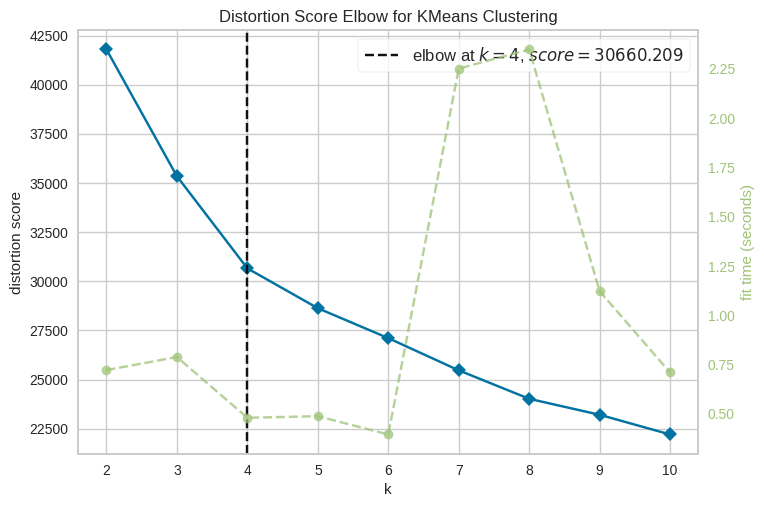

In [419]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(df_features_scaled)
Elbow_M.show();

For n_clusters = 2 The average silhouette_score is: 0.24495130530301984
For n_clusters = 3 The average silhouette_score is: 0.24923210166437085
For n_clusters = 4 The average silhouette_score is: 0.23799965050384472
For n_clusters = 5 The average silhouette_score is: 0.226997627514122
For n_clusters = 6 The average silhouette_score is: 0.19054969728617732
For n_clusters = 7 The average silhouette_score is: 0.199329228251333


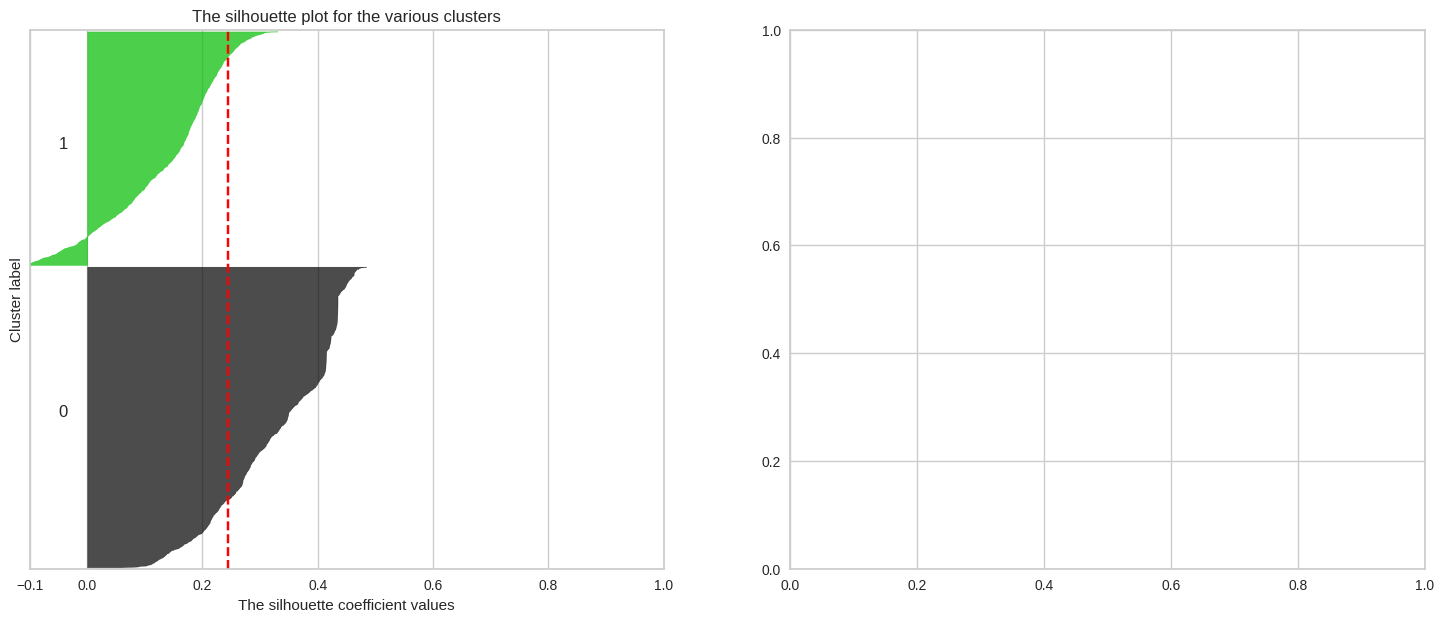

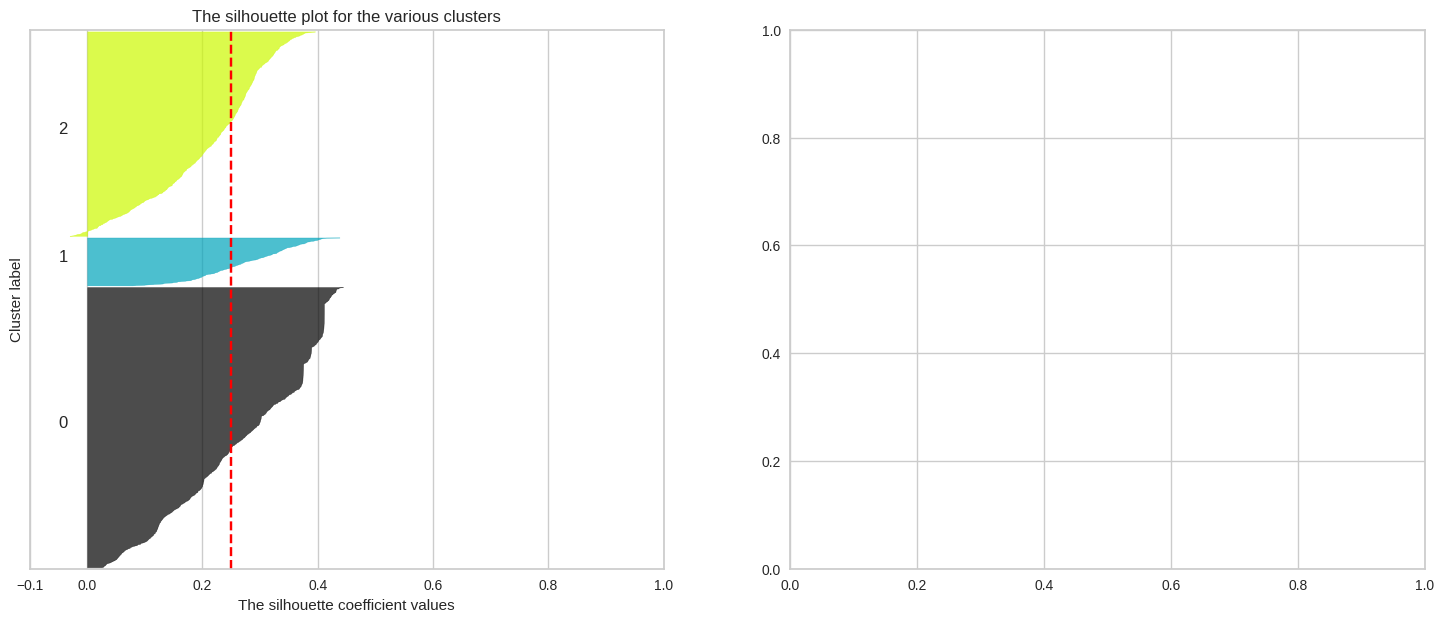

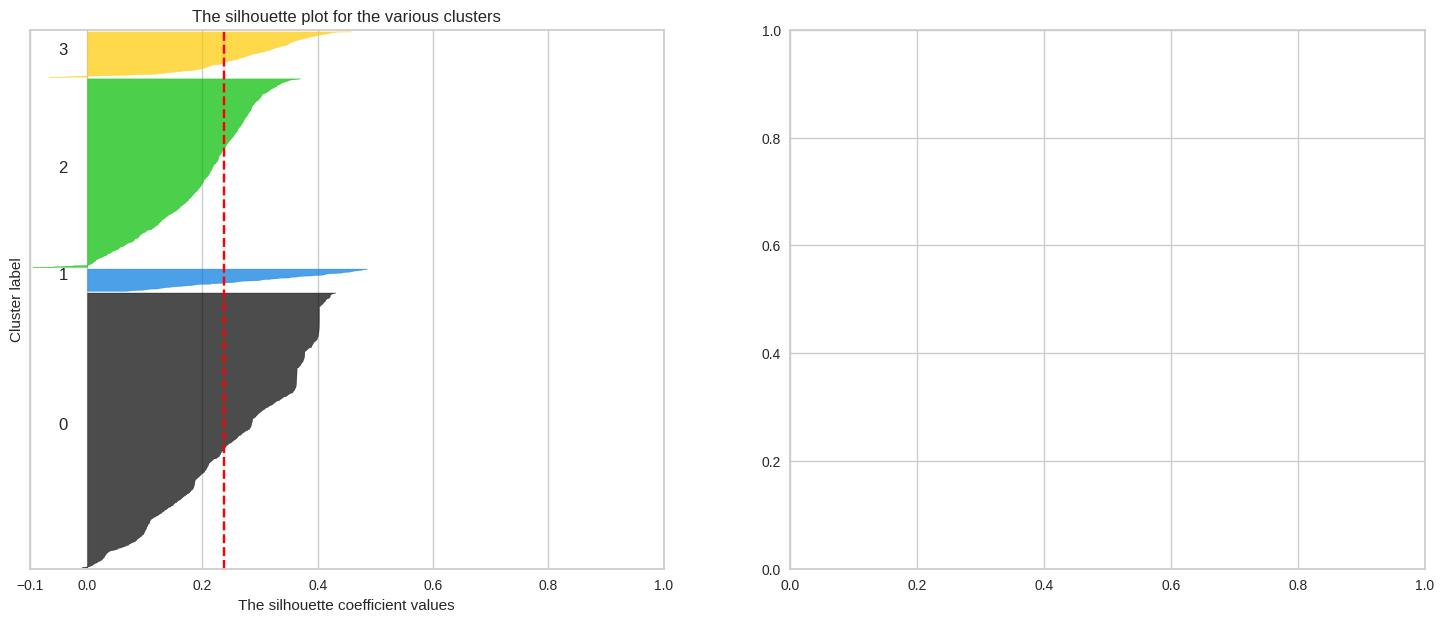

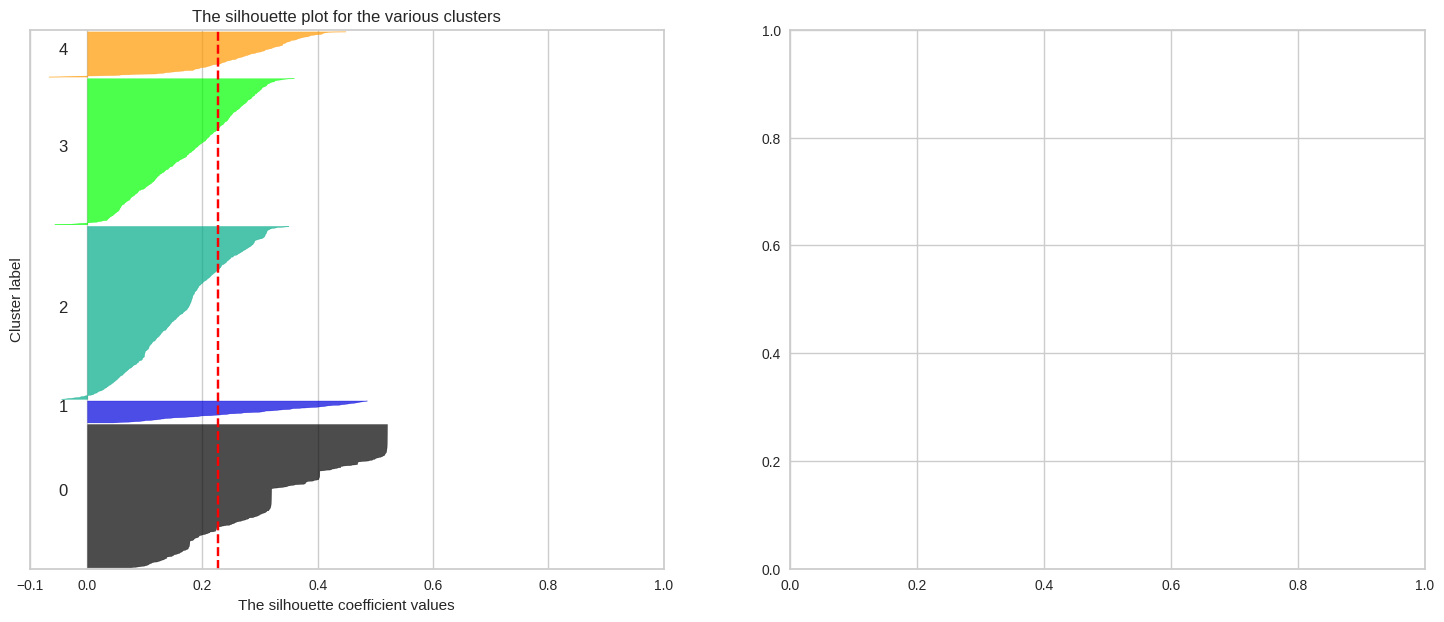

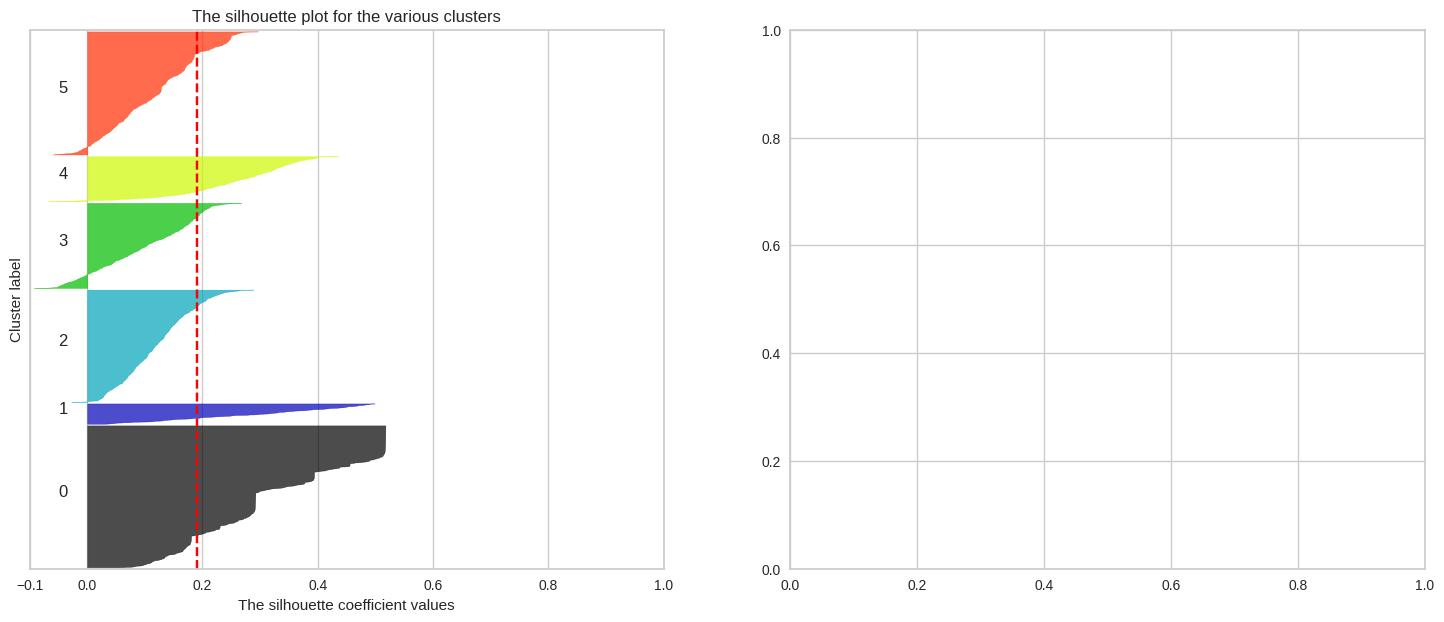

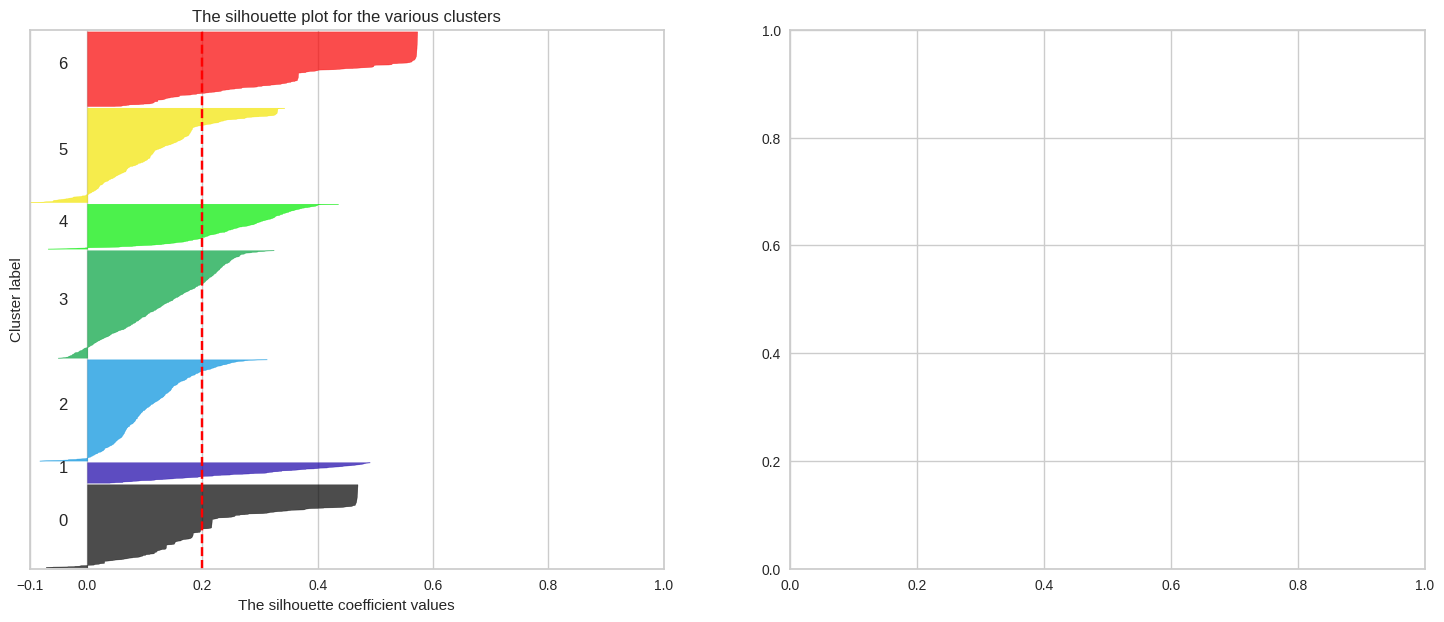

In [420]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

# Generating the sample data
X = df_features_scaled
n_samples, n_features = X.shape
centers = 4
cluster_std = 1

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1, but in this example, all
    # values lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd plot showing the actual clusters formed
    colors = cm

Fit & Predict the model

In [421]:
# Initiating the K-means Clustering model
KM = KMeans(n_clusters=4, random_state=666)

In [422]:
# Fit model and predict clusters
yhat_KM = KM.fit_predict(df_features_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [423]:
# create a new column in the scaled dataframe with the cluster labels
df_features_scaled = pd.DataFrame(df_features_scaled, columns=df_features.columns)
df_features_scaled["Clusters"] = pd.Series(yhat_KM, index=df_features_scaled.index)

In [424]:
# Adding the Clusters feature to the original dataframe.
df["Clusters"] = df_features_scaled["Clusters"]

In [425]:
# calculate Silhouette Coefficient
score = silhouette_score(df_features_scaled, yhat_KM)
print(f"For k=4, the Silhouette Coefficient is {score:.2f}")

For k=4, the Silhouette Coefficient is 0.24


Principle Component Analysis

In [426]:
#Initiating PCA to reduce dimentions aka features to 2
pca = PCA(n_components=2)
pca.fit(df_features_scaled)
PCA_ds = pd.DataFrame(pca.transform(df_features_scaled), columns=(["PC1","PC2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,3439.0,-7.024848e-17,2.401472,-2.901243,-2.196355,-0.871821,2.187133,14.945414
PC2,3439.0,4.132264e-18,1.516227,-4.432478,-0.924371,-0.074375,1.060320,4.495151


In [427]:
PCA_ds["Clusters"] = yhat_KM

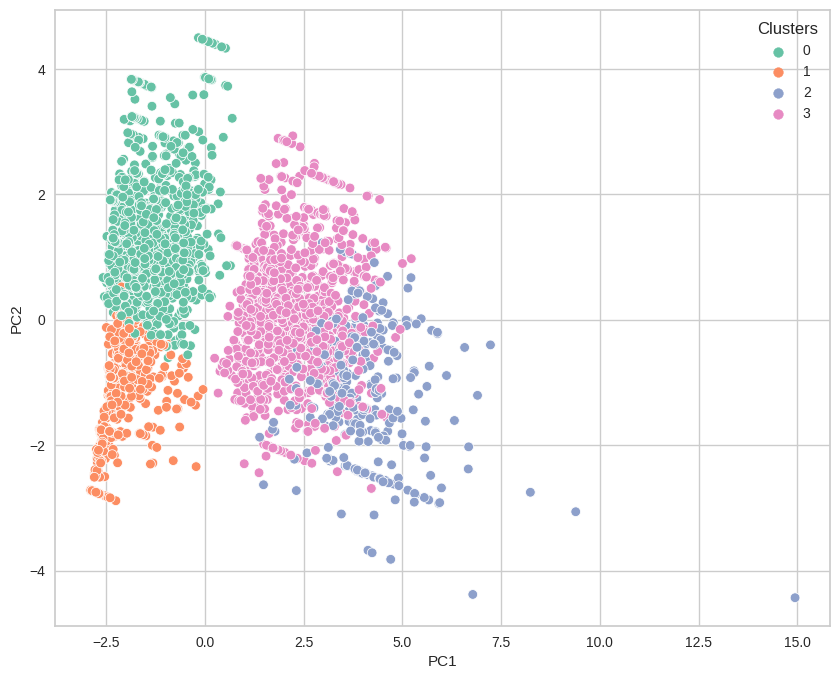

In [428]:
# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()

In [429]:
cluster_results = df

In [430]:
cluster_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3439 entries, 0 to 3438
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   CUST_CODE                        3439 non-null   object        
 1   CUST_LIFESTAGE_LABEL             3439 non-null   object        
 2   CUST_LIFESTAGE_CD                3439 non-null   int64         
 3   CUST_PRICE_SENSITIVITY_LABEL     3439 non-null   object        
 4   CUST_PRICE_SENSITIVITY_CD        3439 non-null   int64         
 5   Start_Date                       3439 non-null   datetime64[ns]
 6   Last_Date                        3439 non-null   datetime64[ns]
 7   FQ                               3439 non-null   int64         
 8   Total_Spend                      3439 non-null   float64       
 9   MTBP                             3439 non-null   float64       
 10  Life_Time                        3439 non-null   int64      

In [431]:
sku_count = cluster_results.groupby('Clusters')['CUST_CODE'].nunique()
print(sku_count)

Clusters
0    1127
1     930
2     310
3    1072
Name: CUST_CODE, dtype: int64


### Feature importance

In [410]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [432]:
#Create variable
X = cluster_results.drop(['CUST_CODE','CUST_LIFESTAGE_LABEL','CUST_LIFESTAGE_CD','CUST_PRICE_SENSITIVITY_LABEL',
                          'CUST_PRICE_SENSITIVITY_CD','Start_Date','Last_Date','Clusters','Life_Time','BASKET_DOMINANT_MISSION_XX',
                          'BASKET_PRICE_SENSITIVITY_XX','BASKET_TYPE_XX','BASKET_DOMINANT_MISSION_Nonfood','MTBP','FQ'], axis=1)

y = df['Clusters']

In [433]:
#train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)

In [434]:
#X variable scaling
scaler = StandardScaler()

x_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(x_scaled)
X_train_scaled.columns = X_train.columns

x_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(x_scaled)
X_test_scaled.columns = X_test.columns

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       676
           1       0.96      0.93      0.95       558
           2       1.00      0.90      0.95       186
           3       0.91      0.97      0.94       643

    accuracy                           0.93      2063
   macro avg       0.95      0.93      0.94      2063
weighted avg       0.94      0.93      0.93      2063



Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       451
           1       0.94      0.89      0.91       372
           2       0.97      0.82      0.89       124
           3       0.89      0.97      0.93       429

    accuracy                           0.91      1376
   macro avg       0.92      0.89      0.90      1376
weighted avg       0.91      0.91      0.91      1376



Standardized Coeff.


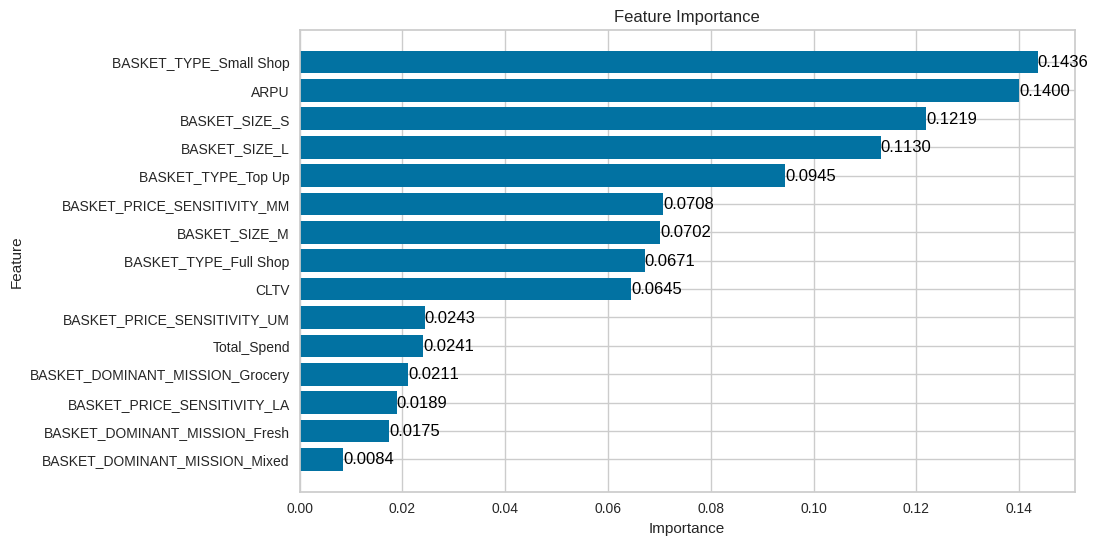

In [435]:
import matplotlib.pyplot as plt

# classification model
def classification_model(clf, X_train, y_train, X_test, y_test, show_feature_importance=True):
    clf_model = clf.fit(X_train, y_train)
    y_hat_train = clf_model.predict(X_train)
    report_train = classification_report(y_train, y_hat_train)

    y_hat_test = clf_model.predict(X_test)
    report_test = classification_report(y_test, y_hat_test)

    print('Training Set Classification Report:')
    print(report_train)
    print('\n')

    print('Test Set Classification Report:')
    print(report_test)
    print('\n')

    if show_feature_importance:
        try:
            print('Standardized Coeff.')
            if hasattr(clf_model, 'coef_'):
                feature_importances = clf_model.coef_[0]
            elif hasattr(clf_model, 'feature_importances_'):
                feature_importances = clf_model.feature_importances_
            else:
                raise AttributeError("Model does not have attribute 'coef_' or 'feature_importances_'")

            coefficients = pd.DataFrame({"Feature": X_train.columns.tolist(), "Importance": feature_importances})
            coefficients = coefficients.sort_values(by="Importance", ascending=False)

            # Reverse sort order
            coefficients = coefficients[::-1]

            plt.figure(figsize=(10, 6))
            plt.barh(coefficients["Feature"], coefficients["Importance"])

            # Add data labels
            for i, v in enumerate(coefficients["Importance"]):
                plt.text(v, i, f"{v:.4f}", color='black', va='center')

            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.title("Feature Importance")
            plt.show()
        except AttributeError as e:
            print(str(e))

# Random forest
rf_clf = RandomForestClassifier(max_depth=4, random_state=0)
classification_model(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test)

### Export Train Result

In [436]:
cluster_results.to_excel('/content/drive/MyDrive/Project MADT8101/Customer_ClusterResult.xlsx', index=False)

In [155]:
summary.to_excel('/content/drive/MyDrive/Project MADT8101/Customer_Result.xlsx', index=False)

In [154]:
raw.to_csv('/content/drive/MyDrive/Project MADT8101/raw.csv', index=False)